<a href="https://colab.research.google.com/github/TR1234567/Transformer-with-time/blob/main/Draft5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pytorch-forecasting wandb onnx arch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.4/140.4 kB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 14.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.7/15.7 MB 38.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.0/983.0 kB 48.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.1/92.1 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 53.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 413.4/413.4 kB 35.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 155.8/155.8 kB 19.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.4/196.4 kB 20.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 257.5/257.5 kB 27.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.5/71.5 kB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━

In [ ]:
!pip uninstall yfinance -y

Found existing installation: yfinance 0.2.36
Uninstalling yfinance-0.2.36:
  Successfully uninstalled yfinance-0.2.36


In [ ]:
!pip install yfinance

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.4/72.4 kB 2.7 MB/s eta 0:00:00


In [2]:
import yfinance
import pandas as pd
import numpy as np
import torch.nn as nn
import torch
from pytorch_forecasting.models.temporal_fusion_transformer.sub_modules import GatedResidualNetwork
import gc
from tqdm.auto import tqdm
import wandb
import math



/usr/local/lib/python3.10/dist-packages/yfinance/base.py:48: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  _empty_series = pd.Series()


In [3]:
wandb.init()


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


# Define Model

In [90]:

class Time2Vector(nn.Module):
    def __init__(self, seq_len):
        super(Time2Vector, self).__init__()
        self.seq_len = seq_len

        # Linear part
        self.linear_weights = nn.Parameter(torch.Tensor(self.seq_len))
        self.linear_bias = nn.Parameter(torch.Tensor(self.seq_len))

        # Periodic part
        self.periodic_weights1 = nn.Parameter(torch.Tensor(self.seq_len))
        self.periodic_bias1 = nn.Parameter(torch.Tensor(self.seq_len))
        self.periodic_weights2 = nn.Parameter(torch.Tensor(self.seq_len))
        self.periodic_bias2 = nn.Parameter(torch.Tensor(self.seq_len))

        self.reset_parameters()

    def reset_parameters(self):
        nn.init.uniform_(self.linear_weights, -0.1, 0.1)
        nn.init.uniform_(self.linear_bias, -0.1, 0.1)
        nn.init.uniform_(self.periodic_weights1, -0.1, 0.1)
        nn.init.uniform_(self.periodic_bias1, -0.1, 0.1)
        nn.init.uniform_(self.periodic_weights2, -0.1, 0.1)
        nn.init.uniform_(self.periodic_bias2, -0.1, 0.1)

    def forward(self, x):
        # Mean reduction across the last dimension
        # x = torch.mean(x, dim=-1)

        # Linear time feature
        # print("self.linear_weights ",self.linear_weights.shape )
        # print("x" , x.shape)
        # print("self.linear_bias", self.linear_bias.shape)
        time_linear = self.linear_weights * x + self.linear_bias
        time_linear = time_linear.unsqueeze(-1)

        # Periodic time features
        time_periodic1 = torch.sin(x * self.periodic_weights1 + self.periodic_bias1)
        time_periodic1 = time_periodic1.unsqueeze(-1)
        time_periodic2 = torch.sin(x * self.periodic_weights2 + self.periodic_bias2)
        time_periodic2 = time_periodic2.unsqueeze(-1)

        # Concatenate linear and periodic features
        return torch.cat([time_periodic1, time_periodic2], dim=-1)


class EncoderLayer(nn.Module):
    """
    model2 = PortfolioTransformer(embed_dim=3027,asset_dim_in=11,asset_dim_out=10,nhead=8,num_model=256,batch_size=1)
    """
    def __init__(self, asset_dim_in, num_model,nhead, dropout=0.1,batch_size=1):  # Add input_dim parameter
        super(EncoderLayer, self).__init__()
        self.embedding = nn.Linear(asset_dim_in+2, num_model) #asset_dim_in = 11, num_model = 256
        self.multihead_attn = nn.MultiheadAttention(num_model, nhead)
        self.grn = GatedResidualNetwork(input_size=num_model,hidden_size=num_model,output_size=num_model)
        # self.grn = GatedResidualNetwork(d_model, dropout, batch_size)
        self.dropout = nn.Dropout(dropout)
        self.layer_norm = nn.LayerNorm(num_model)

    def forward(self, src, src_mask):
        src = self.embedding(src)
        residual = src
        src,_ = self.multihead_attn(src, src, src, attn_mask=src_mask)
        src = self.dropout(src)
        src = residual + src
        src = self.layer_norm(src)

        # residual = src
        src = self.grn(src)
        src = self.dropout(src)
        src = residual + src
        src = self.layer_norm(src)

        return src

class DecoderLayer(nn.Module):
    def __init__(self, num_model, nhead, dropout=0.1):
        super(DecoderLayer, self).__init__()
        self.num_model = num_model
        self.masked_mha = nn.MultiheadAttention(num_model, nhead)
        self.encoder_attn = nn.MultiheadAttention(num_model, nhead, dropout=dropout)
        self.grn = GatedResidualNetwork(input_size=num_model,hidden_size=num_model,output_size=num_model)
        # self.dropout = nn.Dropout(dropout)
        self.layer_norm1 = nn.LayerNorm(num_model)
        self.layer_norm2 = nn.LayerNorm(num_model)

    def forward(self, tgt, memory, src_mask, tgt_mask):
        residual = tgt
        # Ensure tgt, memory, src_mask, and tgt_mask have the correct dimensions
        tgt = tgt.view(tgt.size(0), -1, self.num_model) # Reshape tgt to match the shape of memory
        # print("this is tgt shape {}".format(tgt.shape))
        memory = memory.view(memory.size(0), -1, self.num_model)
        # print("this is memory shape {}".format(memory.shape))
        tgt_mask = torch.ones(1,1)

        # Transpose tgt for masked_mha
        tgt = tgt.transpose(0, 1)

        # Masked multi-head attention within decoder
        tgt,_ = self.masked_mha(tgt, tgt, tgt, attn_mask=tgt_mask)
        # tgt = self.dropout(tgt)

        tgt = self.layer_norm1(residual + tgt)

        # Transpose tgt back to original order
        tgt = tgt.transpose(0, 1)
        # print(tgt.shape)
        # Multi-head attention to encoder output

        tgt= self.encoder_attn(tgt, tgt, memory, attn_mask=src_mask)
        # print(tgt[0].shape)
        # print(tgt[1].shape)
        # tgt = self.dropout(tgt)

        tgt = self.layer_norm2(residual + tgt[0])

        # Gated residual network
        tgt = self.grn(tgt)
        # tgt = self.dropout(tgt)
        tgt = self.layer_norm2(tgt + residual)

        return tgt

# class PortfolioLoss(torch.nn.Module):
#     def __init__(self, cost_rate, risk_free_rate=0.1):
#         super(PortfolioLoss, self).__init__()
#         self.cost_rate = cost_rate
#         self.risk_free_rate = risk_free_rate

#     def forward(self, weights, returns):
#         # Ensure weights and returns are in the correct shape
#         # Weights shape: [batch_size, num_assets]
#         # Returns shape: [batch_size, num_assets]


#         # Calculate portfolio returns
#         # Element-wise multiplication and sum over assets for each instance in the batch
#         portfolio_returns = torch.sum(weights * returns, dim=1)
#         print("portfolio_returns",portfolio_returns)
#         # Calculate portfolio volatility (standard deviation of returns)
#         # You may need to adjust this calculation depending on how your returns are structured
#         portfolio_volatility = torch.std(portfolio_returns, dim=0)
#         print("portfolio_volatility",portfolio_volatility)
#         # Calculate transaction costs
#         # Assuming weights are adjacent allocations, calculate the change in weights
#         deltas = torch.abs(weights[1:] - weights[:-1])
#         transaction_costs = self.cost_rate * torch.sum(deltas, dim=1)

#         # Calculate Sharpe Ratio
#         # Note: risk_free_rate is typically a constant like a treasury bond yield
#         sharpe_ratio = (portfolio_returns.mean() - self.risk_free_rate) / portfolio_volatility

#         # Subtract transaction costs
#         sharpe_ratio -= transaction_costs.mean()
#         print("sharpe_ratio : ",sharpe_ratio)
#         # Negate Sharpe Ratio to minimize this value during training
#         cumulative_returns = np.cumprod(1 + returns) - 1
#         peak, trough = np.argmax(np.maximum.accumulate(cumulative_returns) - cumulative_returns), np.argmax(cumulative_returns)
#         max_drawdown = cumulative_returns[peak] - cumulative_returns[trough]
#         average_return = portfolio_returns.mean()
#         print("average_return", average_return)
#         print("max_drawdown",abs(max_drawdown))
#         calmar = average_return / abs(max_drawdown)

#         total_loss = 0.7 * -sharpe_ratio + 0.3 * max_drawdown
#         # return -sharpe_ratio , -calmar , -max_drawdown
#         return -sharpe_ratio

class PortfolioTransformer(nn.Module):
    def __init__(self, embed_dim,asset_dim_in,asset_dim_out,nhead, num_model,batch_size=1):
        super(PortfolioTransformer, self).__init__()
        self.time2vec = Time2Vector(embed_dim)
        self.encoder = EncoderLayer(asset_dim_in=asset_dim_in,num_model=num_model,nhead=nhead,batch_size=batch_size)
        self.decoder = DecoderLayer(num_model=num_model,nhead=nhead)
        self.linear = nn.Linear(num_model, asset_dim_out)
        self.nhead = nhead

    def forward(self, x):
        seq_len = torch.arange(x.shape[0], device=x.device)
        time_features = self.time2vec(seq_len)

        x = torch.cat([x, time_features], dim=-1)

        src_mask = torch.ones(self.nhead, x.shape[0],x.shape[0], dtype=torch.float32)
        # print("X shape ",x.shape,"src_mask shape ",src_mask.shape)

        x = self.encoder(x, src_mask,)

        x = self.decoder(x, x, src_mask, src_mask)
        x = self.linear(x)
        sign_s_it = torch.sign(x)
        softmax_s_it = torch.nn.functional.softmax(x, dim=-1)
        weighted_s_it = sign_s_it * softmax_s_it
        # abs_sum = torch.sum(torch.abs(weighted_s_it), dim=-1, keepdim=True)
        # normalized_weights = weighted_s_it / abs_sum
        normalized_weights = weighted_s_it.mean(dim=1)
        # print("This is x before softmax",x)

        # print("weight of asset shape",weights.shape)
        # print("weight of asset",weights)
        return normalized_weights

In [91]:
class PortfolioLoss(torch.nn.Module):
    def __init__(self, cost_rate, risk_free_rate=0.1, window_size=5):
        super(PortfolioLoss, self).__init__()
        self.cost_rate = cost_rate
        self.risk_free_rate = risk_free_rate
        self.window_size = window_size

    def forward(self, weights, returns):
        # Ensure weights and returns are in the correct shape
        # Weights shape: [batch_size, num_assets]
        # Returns shape: [batch_size, num_assets]

        # Rolling window approach for Sharpe Ratio
        num_windows = returns.shape[0] - self.window_size + 1
        sharpe_ratios = []

        for i in range(num_windows):
            window_returns = returns[i:i + self.window_size]
            window_weights = weights[i:i + self.window_size]
            portfolio_returns = torch.sum(window_weights * window_returns, dim=1)
            portfolio_volatility = torch.std(portfolio_returns, dim=0)
            window_sharpe_ratio = (portfolio_returns.mean() - self.risk_free_rate) / portfolio_volatility
            sharpe_ratios.append(window_sharpe_ratio)

        # Average the Sharpe Ratios over all windows
        avg_sharpe_ratio = torch.mean(torch.stack(sharpe_ratios))

        # Calculate transaction costs
        deltas = torch.abs(weights[1:] - weights[:-1])
        transaction_costs = self.cost_rate * torch.sum(deltas, dim=1)

        # Adjusted Sharpe Ratio
        adjusted_sharpe_ratio = avg_sharpe_ratio - transaction_costs.mean()

        # Negate Sharpe Ratio to minimize this value during training
        return -adjusted_sharpe_ratio


# Garch Vol

In [92]:
from arch import arch_model

def rolling_garch_volatility(returns, window_size, model_params=None):
    """
    Calculate rolling GARCH(1,1) volatility estimates for a window of returns.

    :param returns: Array-like, the time series of asset returns.
    :param window_size: Integer, the size of the rolling window to fit the GARCH model.
    :param model_params: Dict or None, pre-fitted model parameters to speed up fitting.
    :return: Numpy array of volatility estimates.
    """
    volatilities = np.zeros_like(returns)
    # print(volatilities.shape)

    for i in range(window_size, len(returns)):
        window_returns = returns[i-window_size:i]
        if model_params:
            # Use pre-fitted parameters to initialize the model for faster fitting
            garch = arch_model(window_returns, p=1, q=1, mean='Zero')
            res = garch.fix(model_params)
        else:
            garch = arch_model(window_returns, p=1, q=1, mean='Zero')
            res = garch.fit(disp='off')  # disp='off' turns off the convergence messages

        forecast = res.forecast(horizon=1)
        volatilities[i] = np.sqrt(forecast.variance.values[-1, :])

    # Replace zeros with the first non-zero volatility to avoid issues with early windows
    # print(volatilities.shape)
    first_non_zero = next((v for v in volatilities if np.any(v > 0)), volatilities[window_size-1])
    volatilities[:window_size] = first_non_zero

    return torch.tensor(volatilities, dtype=torch.float32)


# Example usage:
# returns = np.array([...])  # Replace with your returns data
# window_size = 252  # Use a 1-year rolling window if you have daily data
# garch_volatilities = rolling_garch_volatility(returns, window_size)
# Now you can use garch_volatilities in your training loop as needed.


In [93]:
class PortfolioLossGARCH(torch.nn.Module):
    def __init__(self, cost_rate, risk_free_rate=0.1, garch_volatility=None):
        super(PortfolioLossGARCH, self).__init__()
        self.cost_rate = cost_rate
        self.risk_free_rate = risk_free_rate
        self.garch_volatility = garch_volatility  # This should be a time-series of volatility forecasts

    def forward(self, weights, returns):
        # Assume garch_volatility is a tensor with the same length as the returns tensor
        # and represents the forecasted volatility for each time step

        # Calculate portfolio returns and volatility as before
        portfolio_returns = torch.sum(weights * returns, dim=1)
        portfolio_volatility = torch.std(portfolio_returns, dim=0)

        # Adjust portfolio volatility by GARCH forecasted volatility
        # This could be a simple multiplication, or a more complex function
        adjusted_volatility = portfolio_volatility * self.garch_volatility

        # Calculate Sharpe Ratio using adjusted volatility
        sharpe_ratio = (portfolio_returns.mean() - self.risk_free_rate) / adjusted_volatility

        # Transaction costs as before
        deltas = torch.abs(weights[1:] - weights[:-1])
        transaction_costs = self.cost_rate * torch.sum(deltas, dim=1)

        # Adjust Sharpe Ratio for transaction costs and negate for minimization
        adjusted_sharpe_ratio = sharpe_ratio - transaction_costs.mean()
        return -adjusted_sharpe_ratio.mean()


# Jump Diffusion

In [94]:
import numpy as np
import torch

def compute_jump_risk_measure(asset_prices, window_size=30, lambda_estimate=0.1):
    """
    Compute an estimated jump risk measure based on the Merton jump-diffusion model.

    :param asset_prices: A torch.Tensor or np.array of asset prices.
    :param window_size: The size of the rolling window to estimate volatility and jump components.
    :param lambda_estimate: The estimated intensity of the Poisson process (number of jumps per time unit).
    :return: A torch.Tensor representing the estimated jump risk measure.
    """
    # Log returns
    # log_returns = torch.log(asset_prices[1:] / asset_prices[:-1])
    # print(log_returns)

    # Rolling window estimation
    jump_risk_measures = []
    for i in range(len(asset_prices) - window_size + 1):
        window = asset_prices[i:i+window_size]

        # Estimate volatility (diffusion component) as the standard deviation of the window
        sigma_est = window.std()
        # print("sigma_est",sigma_est)
        # Estimate the jump component as jumps exceeding 3 standard deviations
        jump_component = window[window.abs() > 3 * sigma_est]
        # print("jump_component",jump_component)
        # Jump intensity for the window (number of jumps divided by the window size)
        jump_intensity = len(jump_component) / window_size
        # print("jump_intensity",jump_intensity)
        # Estimating jump size variance as variance of the jump components
        jump_size_variance = jump_component.var() if len(jump_component) > 1 else torch.tensor(0.0)

        # Combine the estimates to form a jump risk measure
        # Here we use a simple approach: jump intensity times jump size variance
        # More sophisticated methods could be used in practice
        jump_risk_measure = jump_intensity * jump_size_variance
        # print("jump_risk_measure",jump_risk_measure)

        jump_risk_measures.append(jump_risk_measure)

    # Return the mean jump risk measure over all windows
    return torch.tensor(jump_risk_measures).mean()



In [95]:
class PortfolioLossWithJumpRisk(nn.Module):
    def __init__(self, asset_names, cost_rate, risk_free_rate=0.1, initial_cash=10000):
        super(PortfolioLossWithJumpRisk, self).__init__()
        self.asset_names = asset_names
        self.cost_rate = cost_rate
        self.risk_free_rate = risk_free_rate
        self.cash = initial_cash
        self.weights = []
        self.all_weights = []
        self.cumulative_profit = 0
        self.cumulative_returns = 0
        self.port_value = []
        self.value_over_time = []
        self.returns = []
        self.sharpe =[]
        self.sharpe_ratio_jump = []
        self.sharpe_ratio_garch = []
        self.adjusted_volatility_jump = []
        self.adjusted_volatility_garch = []
        self.portfolio_volatility = []
        self.portfolio = {asset: 0 for asset in asset_names}



    def forward(self, weights, returns, jump_risk_measure, asset_prices,is_first_run,garch_volatility):
        # Rebalance portfolio
        # self.rebalance_portfolio(weights, asset_prices)
        print("weights",weights[-1])
        print("returns",returns[-1])
        print("asset_prices",asset_prices[-1])
        last_weights = weights[-1]
        last_returns = returns[-1]
        last_asset_prices = asset_prices[-1]
        """
        self.port_value[-1] = initial_value tensor(10000.4346, grad_fn=<AddBackward0>)
        self.value_over_time[-2] = current_value [array([ 873.9554 , 1178.7743 , 1289.7609 ,  828.3345 , 1149.2574 ,772.2986 ,  801.2426 ,  967.49207, 1004.6419 , 1134.2424 ],dtype=float32),
        tensor(10000.4346, grad_fn=<AddBackward0>)]
        """
        if is_first_run:
            print("initial Weight",self.weights)
            self.weights.append(last_weights.detach().numpy())
            print("initial Weight add",self.weights)
            print("self.asset_names",self.asset_names)
            print("portfolio",self.portfolio)
            self.portfolio = {asset: unit for asset,unit in zip(self.asset_names,self.initialize_portfolio(last_asset_prices)[0])}
            print("First portfolio unit",self.portfolio)

            self.port_value.append(self.calculate_portfolio_value(self.portfolio.values(), last_asset_prices))
            print("First port_value",self.port_value)
            self.value_over_time.append(self.port_value[-1])
        else:
            # print("last weight",self.weights[-1])
            # print("new weight",last_weights)
            self.portfolio = {asset: unit for asset,unit in zip(self.asset_names,self.update_portfolio_units(last_asset_prices,last_weights.detach().numpy(),self.cost_rate))}
            print("portfolio",self.portfolio)
            self.port_value.append(self.calculate_portfolio_value(self.portfolio.values(), last_asset_prices))
            self.value_over_time.append((self.port_value[-2] - self.port_value[-1])+ self.port_value[-1])
            self.returns.append(self.calculate_return(self.port_value[-1], self.port_value[-2]))
            self.cumulative_profit = self.cumulative_profit + (self.calculate_return(self.port_value[-1], self.port_value[-2]))
            self.cumulative_returns = self.cumulative_returns + (self.calculate_return(self.port_value[0], self.port_value[-1]))

        # Calculate portfolio returns
        portfolio_returns = torch.sum(weights * returns, dim=1)

        # Calculate portfolio volatility
        portfolio_volatility = torch.std(portfolio_returns, dim=0)

        # Adjust volatility for jump risk
        adjusted_volatility_jump = portfolio_volatility * (1 + jump_risk_measure)
        adjusted_volatility_garch = portfolio_volatility * (1 + garch_volatility)
        # Calculate the Sharpe Ratio using adjusted volatility
        sharpe_ratio = (portfolio_returns.mean() - self.risk_free_rate) / portfolio_volatility
        sharpe_ratio_jump = (portfolio_returns.mean() - self.risk_free_rate) / adjusted_volatility_jump
        sharpe_ratio_garch = (portfolio_returns.mean() - self.risk_free_rate) / adjusted_volatility_garch

        # Compute transaction costs
        deltas = torch.abs(weights[1:] - weights[:-1])
        transaction_costs = self.cost_rate * torch.sum(deltas, dim=1)

        # Adjust Sharpe Ratio for transaction costs
        adjusted_sharpe_ratio = sharpe_ratio - transaction_costs.mean()


        cumulative_returns = np.cumprod(1 + returns) - 1
        peak, trough = np.argmax(np.maximum.accumulate(cumulative_returns) - cumulative_returns), np.argmax(cumulative_returns)
        max_drawdown = cumulative_returns[peak] - cumulative_returns[trough]

        print("max_drawdown",abs(max_drawdown))
        calmar = portfolio_returns / abs(max_drawdown)

        total_loss = 0.7 * -sharpe_ratio + 0.3 * max_drawdown
        print("total_loss",total_loss)

        # Return the negative Sharpe Ratio for minimization
        self.all_weights.append(weights)
        self.weights.append(last_weights)
        self.returns.append(self.returns)
        self.sharpe.append(sharpe_ratio)
        self.sharpe_ratio_jump.append(sharpe_ratio_jump)
        self.sharpe_ratio_garch.append(sharpe_ratio_garch)
        self.portfolio_volatility.append(portfolio_volatility)
        self.adjusted_volatility_jump.append(adjusted_volatility_jump)
        self.adjusted_volatility_garch.append(adjusted_volatility_garch)
        return -sharpe_ratio, portfolio_returns, portfolio_volatility,sharpe_ratio,transaction_costs.mean(),self.cumulative_profit,self.cumulative_returns
    def initialize_portfolio(self, asset_prices):
        """
        Initialize the portfolio units based on the initial investment and weights.

        :param asset_names: List of asset names.
        :param asset_prices: List of current asset prices.
        :param initial_weights: List of initial weights of assets in the portfolio.
        :param total_money: Total initial money in the portfolio.
        :return: List of units for each asset based on initial weights.
        """

        # Calculate initial units bought for each asset
        initial_units = [(weight * self.cash) / price for weight, price in zip(self.weights, asset_prices)]

        return initial_units

    def calculate_portfolio_value(self,asset_units, asset_prices):
        """
        Calculate the total value of the portfolio.

        :param asset_units: List of units held for each asset.
        :param asset_prices: List of current prices for each asset.
        :return: Total value of the portfolio.

        """
        print("asset_units",asset_units)
        print("asset_prices",asset_prices)
        return sum(unit * price for unit, price in zip(asset_units, asset_prices))
    def calculate_return(self,initial_value, current_value):
        """
        Calculate the return of the portfolio.

        :param initial_value: The initial value of the portfolio.
        :param current_value: The current value of the portfolio.
        :return: The return as a percentage.
        """
        print("current_value {} - initial_value {} = {}".format(current_value,initial_value,((current_value - initial_value) / initial_value) * 100))

        return ((current_value - initial_value) / initial_value) * 100


    def update_portfolio_units(self, asset_prices, next_weights, transaction_cost_rate):
        """
        Initialize and update the portfolio units to match new weights, considering transaction costs.

        :param asset_names: List of asset names.
        :param asset_prices: List of current asset prices.
        :param initial_weights: List of initial weights of assets in the portfolio.
        :param total_money: Total initial money in the portfolio.
        :param next_weights: List of target weights for the assets.
        :param transaction_cost_rate: Transaction cost rate (as a decimal).
        :return: Updated list of units for each asset.

        """
        print("self.weights[-1]",self.weights[-1])
        print("asset_prices",asset_prices)

        # Calculate initial units bought for each asset
        initial_units = [(weight * self.cash) / price for weight, price in zip(self.weights[-1], asset_prices)]
        print("initial_units",initial_units)

        # Calculate new cost allocation in monetary value
        next_cost = [weight * self.cash for weight in next_weights]
        # Calculate new allocation in units considering the current prices
        next_units = [cost / price for cost, price in zip(next_cost, asset_prices)]
        print("next_units",next_units)
        # Initialize adjustments list
        adjustments = []

        # Calculate adjustments with transaction cost
        for i in range(len(self.asset_names)):
            # Raw adjustment amount in units (without transaction costs)

            raw_adjustment = next_units[i] - initial_units[i]
            print("raw_adjustment",raw_adjustment)

            # Adjust for transaction cost
            if raw_adjustment > 0:  # Buying
                net_adjustment = raw_adjustment / (1 + transaction_cost_rate)
            else:  # Selling
                net_adjustment = raw_adjustment * (1 - transaction_cost_rate)

            adjustments.append(net_adjustment)

        # Update asset units based on adjustments
        updated_units = [initial + adjustment for initial, adjustment in zip(initial_units, adjustments)]

        return updated_units

# Prepare data

In [11]:
Tickers = ["^GSPC", "^IXIC", "^TNX", "^SPGSCI", "^VIX", "VTI"]
Crypto = ["BTC-USD", "ETH-USD", "BNB-USD", "XRP-USD", "USDT-USD"]
Asset = Tickers+Crypto
start="2012-01-01"
end="2022-12-31"

In [12]:
Asset.remove("^VIX")

In [13]:
Asset

['^GSPC',
 '^IXIC',
 '^TNX',
 '^SPGSCI',
 'VTI',
 'BTC-USD',
 'ETH-USD',
 'BNB-USD',
 'XRP-USD',
 'USDT-USD']

In [14]:
Stock_df = yfinance.download(Tickers, start=start, end=end, interval="1d")
Crypto_df = yfinance.download(Crypto, start=start, end=end, interval="1d")

[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  5 of 5 completed


In [15]:
def clean_stock(df,col):
    df = df.fillna(0)
    return df[col]
def clean_crypto(df,col):
    df = df.fillna(method='ffill').fillna(method='bfill')
    return df[col]

In [16]:
Stock_df = clean_stock(Stock_df,"Adj Close")
Crypto_df = clean_crypto(Crypto_df,"Adj Close")


In [17]:
Stock_df_pred = yfinance.download(Tickers, start=end,  interval="1d")
Crypto_df_pred = yfinance.download(Crypto, start=end,  interval="1d")

[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  5 of 5 completed


In [18]:
Stock_df_pred = clean_stock(Stock_df_pred,"Adj Close")
Crypto_df_pred = clean_crypto(Crypto_df_pred,"Adj Close")

In [19]:
before = Stock_df[:"2014-09-17"]
after = Stock_df["2014-09-17":]
after_concat = pd.concat([after,Crypto_df],axis=1).fillna(method='bfill')

In [20]:
test_data = pd.concat([Stock_df_pred,Crypto_df_pred],axis=1).fillna(method='bfill')

In [21]:
mu = before.rolling(1).mean()
mu.drop('^VIX',axis=1,inplace=True)
returns_tensor = torch.tensor(mu.values, dtype=torch.float32)

In [22]:
mu2 = after_concat.rolling(1).mean()
mu2.drop('^VIX',axis=1,inplace=True)
returns_tensor2 = torch.tensor(mu2.values, dtype=torch.float32)

In [23]:
mu_test = test_data.rolling(1).mean()
mu_test.drop('^VIX',axis=1,inplace=True)
returns_tensor_test = torch.tensor(mu_test.values, dtype=torch.float32)[:50]

In [24]:
after_concat_tensor = torch.tensor(after_concat.values, dtype=torch.float32)


In [25]:
test_tensor = torch.tensor(test_data.values, dtype=torch.float32)[:50]


In [26]:
def eda_and_feature_engineering(df):
    # Calculate moving average
    moving_average_df = df.rolling(window=20).mean().dropna()
    moving_average_df = moving_average_df.add_suffix('_MA20')

    # Calculate moving average convergence divergence (MACD)
    exp1 = df.ewm(span=12, adjust=False).mean()
    exp2 = df.ewm(span=26, adjust=False).mean()
    macd = (exp1 - exp2).dropna()
    macd = macd.add_suffix('_MACD')

    # Calculate relative strength index (RSI)
    delta = df.diff(1).dropna()
    up = delta.clip(lower=0)
    down = -delta.clip(upper=0)
    roll_up = up.rolling(window=14).mean()
    roll_down = down.rolling(window=14).mean()
    rs = roll_up / roll_down
    rsi = (100.0 - (100.0 / (1.0 + rs))).dropna()
    rsi = rsi.add_suffix('_RSI')

    # Note: Stochastic Oscillator calculation was mentioned but not implemented.
    # Implementing stochastic oscillator calculation
    low_14 = df.rolling(window=14).min()
    high_14 = df.rolling(window=14).max()
    stochastic_oscillator = 100 * (df - low_14) / (high_14 - low_14)
    stochastic_oscillator = stochastic_oscillator.dropna().add_suffix('_SO')

    return moving_average_df, macd, rsi


In [27]:
moving_average_df, macd,rsi = eda_and_feature_engineering(after_concat)

In [28]:
moving_average_df2, macd2,rsi2 = eda_and_feature_engineering(test_data)

In [29]:
final_input = pd.concat([after_concat,moving_average_df,macd,rsi],axis=1).fillna(method='bfill')

In [30]:
final_test = pd.concat([test_data,moving_average_df2,macd2,rsi2],axis=1).fillna(method='bfill')


In [31]:
final_mu = final_input.rolling(1).mean()
final_mu.drop('^VIX',axis=1,inplace=True)
returns_tensor = torch.tensor(final_mu.values, dtype=torch.float32)

In [32]:
final_input_tensor = torch.tensor(final_input.values, dtype=torch.float32)


In [33]:
mu_test = final_test.rolling(1).mean()
mu_test.drop('^VIX',axis=1,inplace=True)
returns_tensor_test = torch.tensor(mu_test.values, dtype=torch.float32)

# Start Training

In [96]:
after_concat.shape

(3027, 11)

In [97]:
config = dict(
    epochs=1,
    embed_dim=15,
    asset_dim_in=11,
    asset_dim_out=10,
    classes=10,
    cost_rate=0.01,
    batch_size=1,
    learning_rate=0.005,
    Asset=Asset,
    dataset="Price data",
    architecture="Transformer",
    desc="All data " )

In [98]:
def make(config):

    # Make the model
    model = PortfolioTransformer(embed_dim=config.embed_dim,asset_dim_in=config.asset_dim_in,asset_dim_out=10,nhead=8,num_model=256,batch_size=1)

    # Make the loss and optimizer

    optimizer = torch.optim.Adam(model.parameters(), lr=config.learning_rate)

    return model, optimizer

In [99]:
from sklearn.preprocessing import StandardScaler
def prepare_input(dataframe):
    # Normalize the data
    scaler = StandardScaler()
    normalized_data = scaler.fit_transform(dataframe.values)


    # Convert to tensor
    tensor_data = torch.tensor(normalized_data, dtype=torch.float32)

    return tensor_data

def prepare_output(dataframe):
    # Normalize the data
    mu = dataframe.rolling(1).mean()
    mu.drop('^VIX',axis=1,inplace=True)
    scaler = StandardScaler()
    normalized_data = scaler.fit_transform(mu.values)




    # Convert to tensor
    tensor_data = torch.tensor(normalized_data, dtype=torch.float32)

    return tensor_data

In [100]:
def train(model, df,df_y,optimizer, config):
    wandb.watch(model, log="all", log_freq=10)

    window_size = config.embed_dim
    prediction_length = config.embed_dim
    total_batches = (len(df) - window_size - prediction_length + 1) * config.epochs
    example_ct = 0
    batch_ct = 0
    print("Start Epoch")
    is_first_run = True
    portfolio_manager = PortfolioLossWithJumpRisk(asset_names=config.Asset, cost_rate=config.cost_rate)
    for epoch in tqdm(range(config.epochs)):
        for start_idx in range(len(df) - window_size - prediction_length + 1):
            print("start index ",start_idx )
            end_idx = start_idx + window_size
            next_end_idx = end_idx + prediction_length
            print("End idx {} : Next end idx {}".format(end_idx,next_end_idx ))
            input_sequence = df.iloc[start_idx:end_idx]
            target_sequence = df_y.iloc[end_idx:next_end_idx]

            model_input = prepare_input(input_sequence)
            model_target = prepare_output(target_sequence)
            garch_volatility = rolling_garch_volatility(model_target,config.embed_dim)
            jump_risk_measure = compute_jump_risk_measure(model_input,window_size=config.embed_dim)

            # loss = train_batch(model_input, model_target, model, optimizer, config.cost_rate,garch_volatility)
            loss,portfolio_returns, adjusted_volatility,sharpe_ratio,transaction_costs,weights,cumulative_profit,cumulative_returns = train_batch(portfolio_manager,config,model_input, model_target, model, optimizer ,jump_risk_measure,input_sequence,is_first_run,garch_volatility)
            example_ct += len(model_input)
            batch_ct += 1
            is_first_run = False


            if ((batch_ct + 1) % 25) == 0:
                train_log(batch_ct,portfolio_manager,portfolio_returns, adjusted_volatility,sharpe_ratio,transaction_costs,cumulative_profit,cumulative_returns)
        return portfolio_manager

def train_batch(portfolio_manager,config,X, returns_tensor, model, optimizer,jump_risk_measure,input_sequence,is_first_run,garch_volatility):
    weights = model(X)
    optimizer.zero_grad()

    loss, portfolio_returns, adjusted_volatility,sharpe_ratio,transaction_costs,cumulative_profit,cumulative_returns = portfolio_manager(weights,returns_tensor,jump_risk_measure,input_sequence[config.Asset].values,is_first_run,garch_volatility)
    # loss = PortfolioLossGARCH(cost_rate=cost_rate,garch_volatility=garch_volatility)(weights, returns_tensor)
    # print("Loss Shape",loss.shape)
    loss.backward()
    optimizer.step()
    gc.collect()
    return loss, portfolio_returns, adjusted_volatility,sharpe_ratio,transaction_costs,weights,cumulative_profit,cumulative_returns


def train_log(epoch,portfolio_manager,portfolio_returns, adjusted_volatility,sharpe_ratio,transaction_costs,cumulative_profit,cumulative_returns):
    # Example of logging additional portfolio metrics
    portfolio_volatility = adjusted_volatility

    # wandb.log({
    #     "epoch": epoch,
    #     "portfolio_value": portfolio_manager.port_value,
    #     # "portfolio_returns": portfolio_returns,
    #     "portfolio_volatility": portfolio_volatility,
    #     "sharpe_ratio": sharpe_ratio,
    #     "port_return":portfolio_manager.returns,
    #     # "transaction_costs":transaction_costs,
    #     "cumulative_profit":cumulative_profit,
    #     "cumulative_returns":cumulative_returns
    #     # "max_drawdown": max_drawdown,
    # })

In [101]:
def model_pipeline(hyperparameters):

    # tell wandb to get started
    with wandb.init(project="Portfolio Transformer", config=hyperparameters):
      # access all HPs through wandb.config, so logging matches execution!
      config = wandb.config

      # make the model, data, and optimization problem
      model, optimizer = make(config)
      # print(model)

      # and use them to train the model
      port = train(model,after_concat,after_concat,optimizer, config)
      # test(model,final_test,test_data,config)

      # and test its final performance
      # test(model, final_test,test_data,config)

    return model,port

In [102]:
def test(model, df, df_y,config):
    wandb.watch(model, log="all", log_freq=10)

    window_size = config.embed_dim
    prediction_length = config.embed_dim
    total_batches = (len(df) - window_size - prediction_length + 1) * config.epochs
    example_ct = 0
    batch_ct = 0

    print("Start Epoch")
    for epoch in tqdm(range(config.epochs)):
        for start_idx in range(len(df) - window_size - prediction_length + 1):
            print("start index ",start_idx )
            end_idx = start_idx + window_size
            next_end_idx = end_idx + prediction_length
            print("End idx {} : Next end idx", end_idx,next_end_idx )
            input_sequence = df.iloc[start_idx:end_idx]
            target_sequence = df_y.iloc[end_idx:next_end_idx]

            model_input = prepare_input(input_sequence)
            model_target = prepare_output(target_sequence)
            jump_risk_measure = compute_jump_risk_measure(model_input,window_size=config.embed_dim)

            loss,portfolio_returns, adjusted_volatility,sharpe_ratio,transaction_costs,weights,portfolio_manager = test_model(model,model_input, model_target, config.cost_rate,jump_risk_measure,input_sequence,config)
            example_ct += len(model_input)
            batch_ct += 1

            if ((batch_ct + 1) % 25) == 0:
                train_log(total_batches,portfolio_manager,portfolio_returns, adjusted_volatility,sharpe_ratio,transaction_costs)

In [103]:
def test_model(model, Y,returns_tensor_y, cost_rate,jump_risk_measure,input_sequence,config):
    model.eval()

    # Run the model on some test examples
    with torch.no_grad():
        weights = model(Y)
        portfolio_manager = PortfolioLossWithJumpRisk(asset_names=config.Asset, cost_rate=cost_rate,asset_prices=input_sequence)
        loss, portfolio_returns, adjusted_volatility,sharpe_ratio,transaction_costs = portfolio_manager(weights,returns_tensor,jump_risk_measure,input_sequence[config.Asset].values)

        wandb.log({"test_loss": loss})



    # Save the model in the exchangeable ONNX format
    torch.onnx.export(model, Y, "model.onnx")
    wandb.save("model.onnx")
    return loss, portfolio_returns, adjusted_volatility,sharpe_ratio,transaction_costs,weights

# Create Benchmark

In [104]:
model,port  = model_pipeline(config)

Start Epoch


  0%|          | 0/1 [00:00<?, ?it/s]

Streaming output truncated to the last 5000 lines.
initial_units [tensor(-1.7610e-06, grad_fn=<DivBackward0>), tensor(-8.0844e-08, grad_fn=<DivBackward0>), tensor(-0.0003, grad_fn=<DivBackward0>), tensor(26.9576, grad_fn=<DivBackward0>), tensor(0.0008, grad_fn=<DivBackward0>), tensor(-1.5292e-06, grad_fn=<DivBackward0>), tensor(-8.5991e-06, grad_fn=<DivBackward0>), tensor(-0.0002, grad_fn=<DivBackward0>), tensor(-0.0054, grad_fn=<DivBackward0>), tensor(-0.0005, grad_fn=<DivBackward0>)]
next_units [-1.3931049717822847e-06, -5.992329776109242e-08, -0.00033808239536019713, 26.95760607367245, 0.0007317270573319128, -1.0772134061270155e-06, -5.033100609356416e-06, -0.00012334151228044485, -0.0048388998597522605, -0.0003360062632809946]
raw_adjustment tensor(3.6787e-07, grad_fn=<RsubBackward1>)
raw_adjustment tensor(2.0921e-08, grad_fn=<RsubBackward1>)
raw_adjustment tensor(-5.1999e-05, grad_fn=<RsubBackward1>)
raw_adjustment tensor(2.6703e-05, grad_fn=<RsubBackward1>)
raw_adjustment tensor(

<ipython-input-95-1bec317041ff>:169: RuntimeWarning: divide by zero encountered in double_scalars
  next_units = [cost / price for cost, price in zip(next_cost, asset_prices)]


start index  739
End idx 754 : Next end idx 769
weights tensor([-4.1734e-07, -8.9178e-08, -2.6980e-07,  9.9999e-01,  5.7195e-06,
        -7.2628e-08, -1.3179e-07, -2.7562e-08, -1.5094e-07, -4.4289e-08],
       grad_fn=<SelectBackward0>)
returns tensor([ 0.9762,  1.0557,  1.3835, -0.3209,  0.2733,  0.0000,  1.4319,  0.0000,
         0.0000,  0.0000])
asset_prices [2.16365991e+03 5.32866992e+03 0.00000000e+00 3.78339996e+02
 9.80637207e+01 6.16752014e+02 3.20884003e+02 1.99076998e+00
 2.17488006e-01 1.00818002e+00]
self.weights[-1] tensor([-2.3679e-07, -4.7695e-08, -1.2457e-07,  9.9999e-01,  5.3674e-06,
        -5.5148e-08, -1.2740e-07, -2.3020e-08, -1.0395e-07, -3.0196e-08],
       grad_fn=<SelectBackward0>)
asset_prices [2.16365991e+03 5.32866992e+03 0.00000000e+00 3.78339996e+02
 9.80637207e+01 6.16752014e+02 3.20884003e+02 1.99076998e+00
 2.17488006e-01 1.00818002e+00]
initial_units [tensor(-1.0944e-06, grad_fn=<DivBackward0>), tensor(-8.9506e-08, grad_fn=<DivBackward0>), tensor(-inf

<ipython-input-95-1bec317041ff>:169: RuntimeWarning: divide by zero encountered in double_scalars
  next_units = [cost / price for cost, price in zip(next_cost, asset_prices)]


start index  740
End idx 755 : Next end idx 770
weights tensor([-2.4441e-07, -7.7400e-08, -2.3337e-07,  9.9999e-01,  6.0796e-06,
        -6.3234e-08, -1.2836e-07, -2.4872e-08, -1.4043e-07, -4.0969e-08],
       grad_fn=<SelectBackward0>)
returns tensor([ 0.3769,  0.4981,  0.9274, -1.3609, -0.1546,  0.0000,  1.6732,  0.0000,
         0.0000,  0.0000])
asset_prices [2.16365991e+03 5.32866992e+03 0.00000000e+00 3.78339996e+02
 9.80637207e+01 6.18994019e+02 3.20884003e+02 1.99076998e+00
 2.17488006e-01 1.00818002e+00]
self.weights[-1] tensor([-4.1734e-07, -8.9178e-08, -2.6980e-07,  9.9999e-01,  5.7195e-06,
        -7.2628e-08, -1.3179e-07, -2.7562e-08, -1.5094e-07, -4.4289e-08],
       grad_fn=<SelectBackward0>)
asset_prices [2.16365991e+03 5.32866992e+03 0.00000000e+00 3.78339996e+02
 9.80637207e+01 6.18994019e+02 3.20884003e+02 1.99076998e+00
 2.17488006e-01 1.00818002e+00]
initial_units [tensor(-1.9288e-06, grad_fn=<DivBackward0>), tensor(-1.6735e-07, grad_fn=<DivBackward0>), tensor(-inf

<ipython-input-95-1bec317041ff>:169: RuntimeWarning: divide by zero encountered in double_scalars
  next_units = [cost / price for cost, price in zip(next_cost, asset_prices)]


start index  741
End idx 756 : Next end idx 771
weights tensor([-2.9617e-07, -6.3632e-08, -1.2832e-07,  9.9999e-01,  5.4868e-06,
        -5.3160e-08, -1.1352e-07, -2.6169e-08, -1.2211e-07, -3.7112e-08],
       grad_fn=<SelectBackward0>)
returns tensor([-0.3572,  0.0339,  0.0613, -2.3121,  1.7738,  0.0000,  2.6116,  0.0000,
         0.0000,  0.0000])
asset_prices [2.13672998e+03 5.24679004e+03 1.75899994e+00 3.75630005e+02
 9.67578659e+01 6.41072021e+02 3.20884003e+02 1.99076998e+00
 2.17488006e-01 1.00818002e+00]
self.weights[-1] tensor([-2.4441e-07, -7.7400e-08, -2.3337e-07,  9.9999e-01,  6.0796e-06,
        -6.3234e-08, -1.2836e-07, -2.4872e-08, -1.4043e-07, -4.0969e-08],
       grad_fn=<SelectBackward0>)
asset_prices [2.13672998e+03 5.24679004e+03 1.75899994e+00 3.75630005e+02
 9.67578659e+01 6.41072021e+02 3.20884003e+02 1.99076998e+00
 2.17488006e-01 1.00818002e+00]
initial_units [tensor(-1.1439e-06, grad_fn=<DivBackward0>), tensor(-1.4752e-07, grad_fn=<DivBackward0>), tensor(-0.0

<ipython-input-95-1bec317041ff>:169: RuntimeWarning: divide by zero encountered in double_scalars
  next_units = [cost / price for cost, price in zip(next_cost, asset_prices)]


Streaming output truncated to the last 5000 lines.
initial_units [tensor(-1.9266e-16, grad_fn=<DivBackward0>), tensor(0.7909, grad_fn=<DivBackward0>), tensor(-7.9100e-13, grad_fn=<DivBackward0>), tensor(-3.7711e-20, grad_fn=<DivBackward0>), tensor(-5.3588e-18, grad_fn=<DivBackward0>), tensor(-4.2653e-16, grad_fn=<DivBackward0>), tensor(-2.7803e-15, grad_fn=<DivBackward0>), tensor(-1.9775e-14, grad_fn=<DivBackward0>), tensor(-2.8215e-11, grad_fn=<DivBackward0>), tensor(-1.0395e-12, grad_fn=<DivBackward0>)]
next_units [-1.0631406406294427e-14, 0.7908601894341851, -7.026986901863782e-11, -2.3918913898191475e-20, -2.2689418364746037e-13, -1.4545771829031747e-14, -2.480372408353304e-13, -3.7338305164881003e-13, -9.953447524110612e-10, -7.951307594348107e-11]
raw_adjustment tensor(-1.0439e-14, grad_fn=<RsubBackward1>)
raw_adjustment tensor(0., grad_fn=<RsubBackward1>)
raw_adjustment tensor(-6.9479e-11, grad_fn=<RsubBackward1>)
raw_adjustment tensor(1.3792e-20, grad_fn=<RsubBackward1>)
raw_ad

In [ ]:
accummulate_sharpe_ls = [tensor.detach().numpy() for tensor in port.accummulate_sharpe]

In [ ]:
accummulate_sharpe_ls

In [108]:
print(port.__dict__.keys())

dict_keys(['training', '_parameters', '_buffers', '_non_persistent_buffers_set', '_backward_pre_hooks', '_backward_hooks', '_is_full_backward_hook', '_forward_hooks', '_forward_hooks_with_kwargs', '_forward_hooks_always_called', '_forward_pre_hooks', '_forward_pre_hooks_with_kwargs', '_state_dict_hooks', '_state_dict_pre_hooks', '_load_state_dict_pre_hooks', '_load_state_dict_post_hooks', '_modules', 'asset_names', 'cost_rate', 'risk_free_rate', 'cash', 'weights', 'all_weights', 'cumulative_profit', 'cumulative_returns', 'port_value', 'value_over_time', 'returns', 'sharpe', 'sharpe_ratio_jump', 'sharpe_ratio_garch', 'adjusted_volatility_jump', 'adjusted_volatility_garch', 'portfolio_volatility', 'portfolio'])


In [109]:
torch.save(port.value_over_time,"value_over_time.pt")

In [110]:
torch.save(port.port_value,"port_value.pt")

In [111]:
torch.save(port.returns,"returns.pt")

In [112]:
torch.save(port.weights,"weights.pt")

In [113]:
torch.save(port.sharpe,"sharpe.pt")

In [114]:
torch.save(port.sharpe_ratio_jump,"sharpe_ratio_jump.pt")

In [115]:
torch.save(port.sharpe_ratio_jump,"sharpe_ratio_garch.pt")

In [116]:
torch.save(port.sharpe_ratio_jump,"adjusted_volatility_jump.pt")

In [117]:
torch.save(port.adjusted_volatility_garch,"adjusted_volatility_garch.pt")

In [118]:
torch.save(port.portfolio_volatility,"portfolio_volatility.pt")

In [119]:
torch.save(port.portfolio,"portfolio.pt")

In [ ]:
log_data = np.log(after_concat / after_concat.shift(1)).dropna()

/usr/local/lib/python3.10/dist-packages/pandas/core/internals/blocks.py:351: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)


In [ ]:
log_data

Ticker,VTI,^GSPC,^IXIC,^SPGSCI,^TNX,^VIX,BNB-USD,BTC-USD,ETH-USD,USDT-USD,XRP-USD
Date,,,,,,,,,,,
2014-09-18,0.005100,0.004879,0.006824,-0.012054,0.011092,-0.050254,0.000000,-0.074643,0.000000,0.000000,0.000000
2014-09-19,-0.001922,-0.000477,-0.002974,-0.001406,-0.016105,0.006628,0.000000,-0.072402,0.000000,0.000000,0.000000
2014-09-20,-0.009275,-0.008046,-0.011441,-0.009011,-0.008151,0.122634,0.000000,0.035111,0.000000,0.000000,0.000000
2014-09-21,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.024968,0.000000,0.000000,0.000000
2014-09-22,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.008317,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...
2022-12-26,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.004337,0.004610,0.006552,0.000052,0.054305
2022-12-27,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.009774,-0.012048,-0.011626,-0.000145,0.006549
2022-12-28,-0.012670,-0.012093,-0.013609,-0.007907,0.006971,0.022380,-0.010004,-0.009895,-0.018983,-0.000164,-0.032004


In [ ]:
scaler = StandardScaler()
# normalized_data = scaler.fit_transform(after_concat)
normalized_data = pd.DataFrame(scaler.fit_transform(after_concat.values), columns=after_concat.columns, index=after_concat.index)


In [ ]:
normalized_data

,VTI,^GSPC,^IXIC,^SPGSCI,^TNX,^VIX,BNB-USD,BTC-USD,ETH-USD,USDT-USD,XRP-USD
Date,,,,,,,,,,,
2014-09-17,-1.182706,-1.155933,-1.148605,1.331474,0.704126,-0.777287,-0.560558,-0.766356,-0.494628,0.741990,-0.588940
2014-09-18,-1.172524,-1.143954,-1.139254,1.266848,0.743633,-0.856648,-0.560558,-0.768388,-0.494628,0.741990,-0.588940
2014-09-19,-1.176366,-1.145129,-1.143337,1.259362,0.686416,-0.846408,-0.560558,-0.770219,-0.494628,0.741990,-0.588940
2014-09-20,-1.194810,-1.164841,-1.158932,1.211623,0.657808,-0.644165,-0.560558,-0.769348,-0.494628,0.741990,-0.588940
2014-09-21,-1.194810,-1.164841,-1.158932,1.211623,0.657808,-0.644165,-0.560558,-0.769971,-0.494628,0.741990,-0.588940
...,...,...,...,...,...,...,...,...,...,...,...
2022-12-26,1.093019,1.080345,0.584811,1.512301,2.420635,0.374727,0.950922,0.250775,0.398324,-0.740285,-0.130612
2022-12-27,1.093019,1.080345,0.584811,1.512301,2.420635,0.374727,0.965889,0.238255,0.384347,-0.766547,-0.123182
2022-12-28,1.039295,1.024025,0.542923,1.468395,2.457418,0.437448,0.950571,0.228085,0.361872,-0.796242,-0.159033


In [ ]:
returns_daily = normalized_data.pct_change().iloc[1: , :]
returns_daily

,VTI,^GSPC,^IXIC,^SPGSCI,^TNX,^VIX,BNB-USD,BTC-USD,ETH-USD,USDT-USD,XRP-USD
Date,,,,,,,,,,,
2014-09-18,-0.008609,-0.010363,-0.008141,-0.048538,0.056108,0.102100,0.000000,0.002652,0.000000,0.000000,0.000000
2014-09-19,0.003277,0.001027,0.003584,-0.005908,-0.076943,-0.011954,0.000000,0.002384,0.000000,0.000000,0.000000
2014-09-20,0.015678,0.017213,0.013640,-0.037908,-0.041678,-0.238942,0.000000,-0.001132,0.000000,0.000000,0.000000
2014-09-21,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000810,0.000000,0.000000,0.000000
2014-09-22,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.000267,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...
2022-12-26,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.006984,0.019547,0.020224,-0.012555,-0.313946
2022-12-27,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.015739,-0.049923,-0.035090,0.035476,-0.056884
2022-12-28,-0.049152,-0.052132,-0.071627,-0.029033,0.015195,0.167377,-0.015860,-0.042685,-0.058475,0.038738,0.291037


In [ ]:
returns_daily = normalized_data.pct_change().iloc[1: , :]
returns_annual = returns_daily.mean() * 250
# get daily and covariance of returns of the stock
cov_daily = returns_daily.cov()
cov_annual = cov_daily * 250

# empty lists to store returns, volatility and weights of imiginary portfolios
port_returns = []
port_volatility = []
stock_weights = []

# set the number of combinations for imaginary portfolios
num_assets = len(normalized_data.columns)
num_portfolios = 50000

# populate the empty lists with each portfolios returns,risk and weights
for single_portfolio in range(num_portfolios):
    weights = np.random.random(num_assets)
    weights /= np.sum(weights)
    returns = np.dot(weights, returns_annual)
    volatility = np.sqrt(np.dot(weights.T, np.dot(cov_annual, weights)))
    port_returns.append(returns)
    port_volatility.append(volatility)
    stock_weights.append(weights)

# a dictionary for Returns and Risk values of each portfolio
portfolio = {'Returns': port_returns,
             'Volatility': port_volatility}

# extend original dictionary to accomodate each ticker and weight in the portfolio
for counter,symbol in enumerate(normalized_data.columns.tolist()):
    portfolio[symbol+' weight'] = [weight[counter] for weight in stock_weights]

# make a nice dataframe of the extended dictionary
df = pd.DataFrame(portfolio)

# get better labels for desired arrangement of columns
column_order = ['Returns', 'Volatility'] + [stock+' weight' for stock in normalized_data.columns]

# reorder dataframe columns
df = df[column_order]

df.head()

,Returns,Volatility,VTI weight,^GSPC weight,^IXIC weight,^SPGSCI weight,^TNX weight,^VIX weight,BNB-USD weight,BTC-USD weight,ETH-USD weight,USDT-USD weight,XRP-USD weight
0,0.085935,20.050907,0.067765,0.133523,0.093552,0.131197,0.017493,0.022364,0.139649,0.120423,0.068948,0.077919,0.127168
1,0.342090,21.134448,0.041943,0.119350,0.105185,0.008615,0.018622,0.044792,0.152780,0.231083,0.046754,0.107898,0.122978
2,7.615595,60.762967,0.006118,0.061072,0.165774,0.008254,0.045628,0.241893,0.073586,0.070564,0.099952,0.222412,0.004748
3,-6.370239,40.915477,0.185634,0.044686,0.161578,0.073124,0.157331,0.021988,0.178723,0.021618,0.040296,0.087854,0.027166
4,-1.890314,38.891141,0.143164,0.020704,0.145822,0.098764,0.132875,0.087801,0.056492,0.041850,0.084926,0.127401,0.060201


<ipython-input-54-12f3b0c49d86>:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


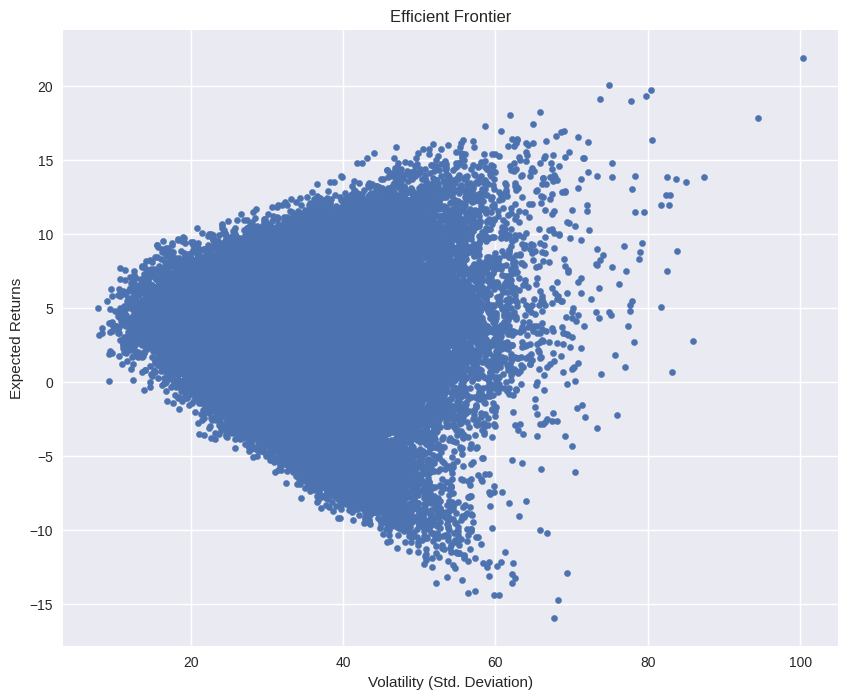

In [ ]:
import matplotlib.pyplot as plt
plt.style.use('seaborn')
df.plot.scatter(x='Volatility', y='Returns', figsize=(10, 8), grid=True)
plt.xlabel('Volatility (Std. Deviation)')
plt.ylabel('Expected Returns')
plt.title('Efficient Frontier')
plt.show()

In [ ]:
min_var_port = df.loc[df['Volatility'].idxmin()]

In [ ]:
max_returns = df.loc[df['Returns'].idxmax()]

Text(0.5, 1.0, 'Efficient Frontier and least risky portfolio')

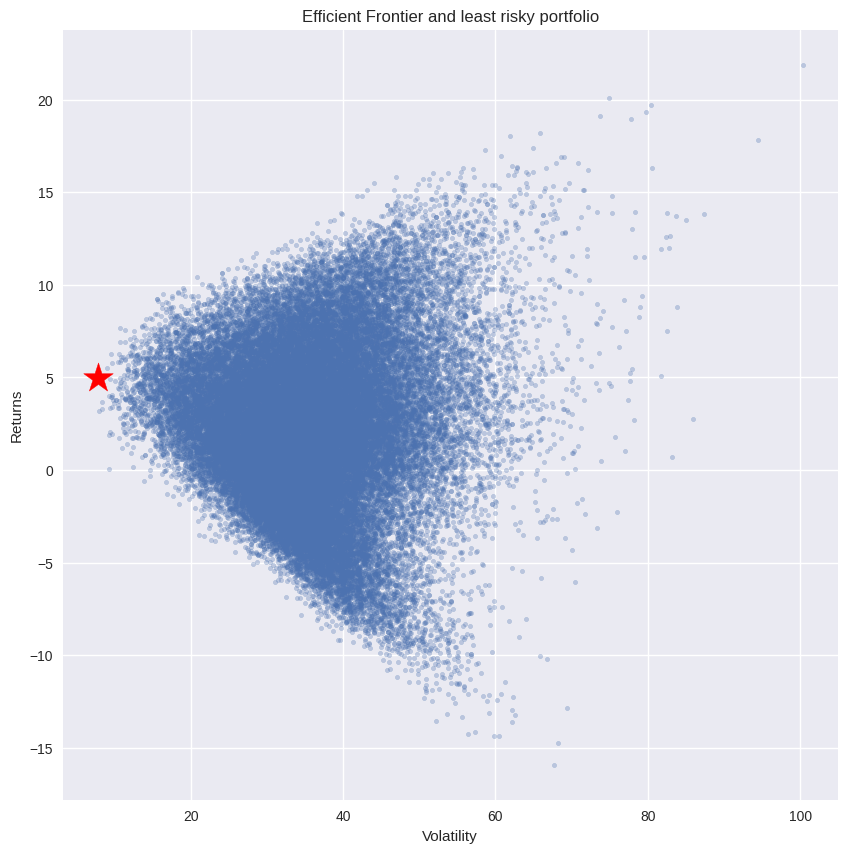

In [ ]:
df.plot.scatter(x='Volatility',y='Returns',grid=True,\
 marker='o', s=10, alpha=0.3,figsize=[10,10])
plt.scatter(x=min_var_port[1],y=min_var_port[0],\
 color='r', marker='*', s=500)
plt.title('Efficient Frontier and least risky portfolio')

Text(0.5, 1.0, 'Efficient Frontier and Most risky portfolio')

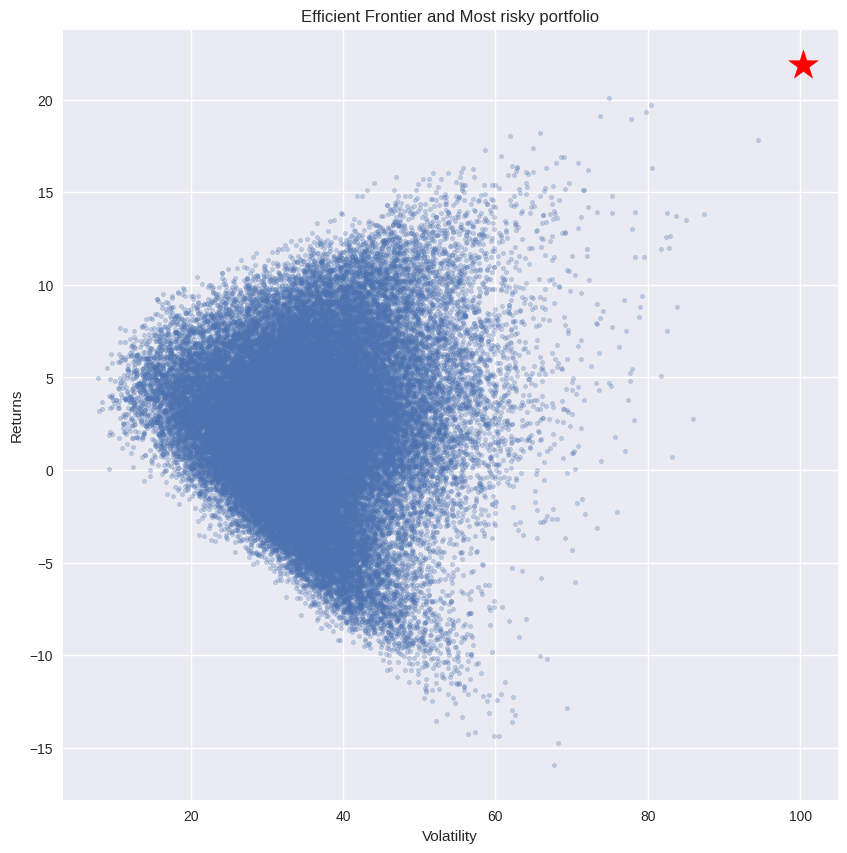

In [ ]:
df.plot.scatter(x='Volatility',y='Returns',grid=True,\
 marker='o', s=10, alpha=0.3,figsize=[10,10])
plt.scatter(x=max_returns[1],y=max_returns[0],\
 color='r', marker='*', s=500)
plt.title('Efficient Frontier and Most risky portfolio')

In [ ]:
window = 20

# Calculate moving average and standard deviation
moving_averages = normalized_data.rolling(window=window).mean()
std_dev = normalized_data.rolling(window=window).std()

# Mean Reversion Strategy
def mean_reversion_strategy(prices, mean, std, std_multiplier=1):
    buy_signal = prices < (mean - std_multiplier * std)
    sell_signal = prices > (mean + std_multiplier * std)
    return buy_signal, sell_signal
Tickers
# Apply strategy
buy_signals, sell_signals = {}, {}
for symbol in Tickers:
    buy_signals[symbol], sell_signals[symbol] = mean_reversion_strategy(normalized_data[symbol], moving_averages[symbol], std_dev[symbol])

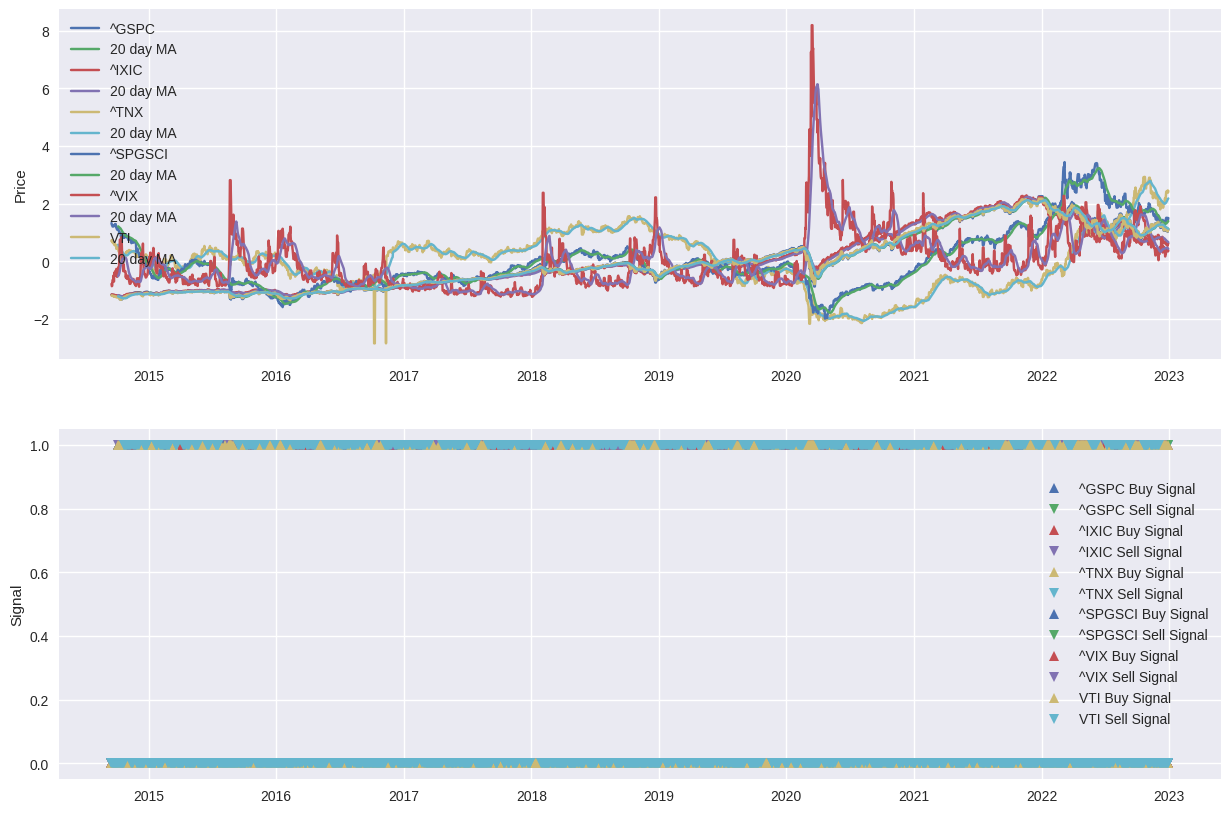

In [ ]:
# Plot the strategy of each stock
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(15, 10))
for symbol in Tickers:
    axes[0].plot(normalized_data[symbol], label=symbol)
    axes[0].plot(moving_averages[symbol], label='{} day MA'.format(window))
    axes[0].set_ylabel('Price')
    axes[0].legend()
    axes[1].plot(buy_signals[symbol], label='{} Buy Signal'.format(symbol), marker='^', linestyle='None')
    axes[1].plot(sell_signals[symbol], label='{} Sell Signal'.format(symbol), marker='v', linestyle='None')
    axes[1].set_ylabel('Signal')
    axes[1].legend()

In [ ]:
def calculate_weights(data):
    returns = data.pct_change().dropna()
    vol = returns.rolling(window=60).std().mean()[:-1]
    inv_vol = 1 / vol
    weights = inv_vol / np.sum(inv_vol)
    return weights * 100  # Convert to percentage

def plot_weights(weights):
    plt.figure(figsize=(12,6))
    weights_sorted = weights.sort_values()
    ax = weights_sorted.plot(kind='barh', color='skyblue')
    plt.title('Risk Parity Weights (%)')
    plt.xlabel('Weights (%)')
    plt.ylabel('Tickers')

    # Adding labels to the bars
    for i, v in enumerate(weights_sorted):
        ax.text(v , i, f"{v:.2f}%", va='center', fontweight='light', fontsize=15)

    plt.tight_layout()
    plt.show()

In [ ]:
weights = calculate_weights(normalized_data)

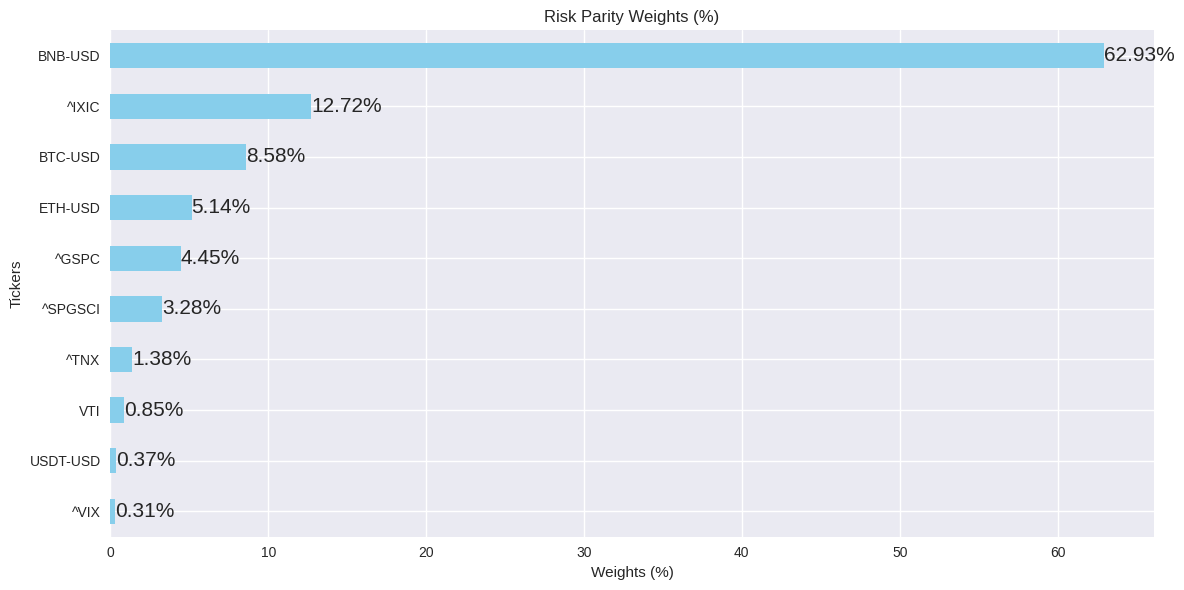

In [ ]:
plot_weights(weights)

In [ ]:
weights = torch.load("weights.pt")


In [ ]:
value_over_time = torch.load("value_over_time.pt")

In [ ]:
returns = torch.load("returns.pt")

In [ ]:
port_value = torch.load("port_value.pt")

In [ ]:
#Create a new dataframe from weights, value_over_time , returns and port_value
weights_df = pd.DataFrame(weights, columns=Asset)

In [ ]:
#Get value of each weights_df asset from tensor to float
weights_df = weights_df.applymap(lambda x: x.item())


/var/folders/pc/gn4drv5d423127l84w13cgfr0000gn/T/ipykernel_13150/2788614324.py:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  weights_df = weights_df.applymap(lambda x: x.item())


In [ ]:
#create sum of weights column
weights_df['sum'] = weights_df.sum(axis=1)

In [ ]:
#Create a new dataframe from value_over_time that is a tensor
value_over_time_ls = [tensor.detach().numpy() for tensor in value_over_time[1:]]
value_over_time_df = pd.DataFrame(value_over_time_ls)


In [ ]:
value_over_time_df

,0
0,4433.956543
1,10000.460938
2,10000.580078
3,10000.414062
4,10000.824219
...,...
2992,10000.000000
2993,10000.000000
2994,10000.000000
2995,10000.000000


In [ ]:
returns_ls = [tensor.detach().numpy() for tensor in returns]

In [ ]:
returns_df = pd.DataFrame(returns_ls)

In [ ]:
returns_df

,0
0,-55.662476
1,-0.001191
2,0.001660
3,-0.004101
4,0.007988
...,...
2992,0.000000
2993,0.000000
2994,0.000000
2995,0.000000


In [ ]:
port_value_ls = [tensor.detach().numpy() for tensor in port_value[1:]]

In [ ]:
port_value_df = pd.DataFrame(port_value_ls)

In [ ]:
port_value_df

,0
0,10000.460938
1,10000.580078
2,10000.414062
3,10000.824219
4,10000.025391
...,...
2992,10000.000000
2993,10000.000000
2994,10000.000000
2995,10000.000000


In [ ]:
weights_df

,^GSPC,^IXIC,^TNX,^SPGSCI,VTI,BTC-USD,ETH-USD,BNB-USD,XRP-USD,USDT-USD,sum
0,1.041932e-01,1.175658e-01,9.764432e-02,1.135463e-01,7.417159e-02,1.073122e-01,0.084536,1.217645e-01,6.974474e-02,1.095210e-01,1.0
1,1.041932e-01,1.175658e-01,9.764432e-02,1.135463e-01,7.417159e-02,1.073122e-01,0.084536,1.217645e-01,6.974474e-02,1.095210e-01,1.0
2,1.232565e-01,2.883321e-01,2.162433e-01,2.711547e-01,6.834128e-02,1.107406e-02,0.002831,4.760972e-03,1.002420e-02,3.981756e-03,1.0
3,5.170262e-02,2.310232e-02,3.698531e-02,2.022323e-01,9.191635e-02,2.327491e-01,0.049121,4.170352e-02,2.306722e-01,3.981540e-02,1.0
4,2.101373e-03,9.757401e-04,1.556227e-03,2.647132e-04,1.623071e-03,2.527278e-01,0.130549,3.189659e-02,5.485209e-01,2.978448e-02,1.0
...,...,...,...,...,...,...,...,...,...,...,...
2994,4.133719e-12,1.379167e-12,8.119328e-12,1.480054e-15,1.141898e-12,9.935840e-11,1.000000,4.336030e-11,2.014216e-11,7.764915e-12,1.0
2995,3.221242e-12,1.005681e-12,6.694439e-12,1.161393e-15,9.329844e-13,8.022199e-11,1.000000,4.278571e-11,1.844998e-11,6.810569e-12,1.0
2996,3.442691e-12,9.709258e-13,6.605753e-12,1.246649e-15,6.764748e-13,8.607039e-11,1.000000,3.577349e-11,1.632322e-11,6.022573e-12,1.0
2997,6.783565e-12,2.344789e-12,1.151836e-11,1.527921e-15,1.930703e-12,1.367295e-10,1.000000,7.952425e-11,4.305710e-11,1.502650e-11,1.0


In [ ]:
price_df = after_concat.drop(columns=["^VIX"]).reset_index(drop=True)

In [ ]:
price_df

,VTI,^GSPC,^IXIC,^SPGSCI,^TNX,BNB-USD,BTC-USD,ETH-USD,USDT-USD,XRP-USD
0,87.565239,2001.569946,4562.189941,590.900024,2.600,1.990770,457.334015,320.884003,1.008180,0.217488
1,88.013016,2011.359985,4593.430176,583.820007,2.629,1.990770,424.440002,320.884003,1.008180,0.217488
2,87.844017,2010.400024,4579.790039,583.000000,2.587,1.990770,394.795990,320.884003,1.008180,0.217488
3,87.033012,1994.290039,4527.689941,577.770020,2.566,1.990770,408.903992,320.884003,1.008180,0.217488
4,87.033012,1994.290039,4527.689941,577.770020,2.566,1.990770,398.821014,320.884003,1.008180,0.217488
...,...,...,...,...,...,...,...,...,...,...
3022,187.638596,3829.250000,10353.230469,610.710022,3.860,244.198288,16919.804688,1226.974365,0.999995,0.365723
3023,187.638596,3829.250000,10353.230469,610.710022,3.860,246.596680,16717.173828,1212.791626,0.999850,0.368126
3024,185.276138,3783.219971,10213.290039,605.900024,3.887,244.141922,16552.572266,1189.986084,0.999686,0.356531
3025,188.682007,3849.280029,10478.089844,602.840027,3.835,246.479721,16642.341797,1201.595337,0.999735,0.342846


In [ ]:
price_df.iloc[0:15].iloc[-1]

VTI           84.790840
^GSPC       1946.160034
^IXIC       4422.089844
^SPGSCI      573.080017
^TNX           2.403000
BNB-USD        1.990770
BTC-USD      383.614990
ETH-USD      320.884003
USDT-USD       1.008180
XRP-USD        0.217488
Name: 14, dtype: float64

In [ ]:
#Create rolling window of 15 days
window_size = 15
prediction_length = 15
total_batches = (len(price_df) - window_size - prediction_length + 1)
example_ct = 0
batch_ct = 0
ls_price = []
for start_idx in range(len(price_df) - window_size - prediction_length + 1):
    end_idx = start_idx + window_size
    next_end_idx = end_idx + prediction_length
    input_sequence = price_df.iloc[start_idx:end_idx].iloc[-1]
    ls_price.append(input_sequence)


In [ ]:
ls_price_df = pd.DataFrame(ls_price)

In [ ]:
ls_price_df.reset_index(drop=True,inplace=True)

In [ ]:
ls_price_df

,VTI,^GSPC,^IXIC,^SPGSCI,^TNX,BNB-USD,BTC-USD,ETH-USD,USDT-USD,XRP-USD
0,84.790840,1946.160034,4422.089844,573.080017,2.403,1.990770,383.614990,320.884003,1.008180,0.217488
1,84.833252,1946.170044,4430.200195,570.000000,2.438,1.990770,375.071991,320.884003,1.008180,0.217488
2,85.783775,1967.900024,4475.620117,565.789978,2.447,1.990770,359.511993,320.884003,1.008180,0.217488
3,85.614029,1964.819946,4454.799805,570.219971,2.425,1.990770,328.865997,320.884003,1.008180,0.217488
4,85.614029,1964.819946,4454.799805,570.219971,2.425,1.990770,320.510010,320.884003,1.008180,0.217488
...,...,...,...,...,...,...,...,...,...,...
2993,195.466873,3990.560059,11143.740234,582.640015,3.611,284.390411,17104.193359,1263.868530,1.000078,0.381749
2994,195.466873,3990.560059,11143.740234,582.640015,3.611,276.278198,17206.437500,1274.619019,1.000107,0.387394
2995,196.926529,4019.649902,11256.809570,596.390015,3.501,271.951691,17781.318359,1320.549194,1.000017,0.395102
2996,195.829315,3995.320068,11170.889648,602.869995,3.503,268.231537,17815.650391,1309.328735,1.000105,0.386414


In [ ]:
#Create dataframe of weights_df mupltiplied by ls_price_df
weighted_price_df = weights_df.iloc[1:,:-1].mul(ls_price_df.values)

In [ ]:
weighted_price_df['sum'] = weighted_price_df.sum(axis=1)

In [ ]:
weighted_price_df

,^GSPC,^IXIC,^TNX,^SPGSCI,VTI,BTC-USD,ETH-USD,BNB-USD,XRP-USD,USDT-USD,sum
1,8.834628e+00,2.288019e+02,4.317920e+02,6.507110e+01,1.782343e-01,2.136339e-01,32.429406,3.907229e+01,7.031525e-02,2.381950e-02,806.487240
2,1.045625e+01,5.611433e+02,9.580009e+02,1.545582e+02,1.666161e-01,2.204590e-02,1.061904,1.527720e+00,1.010620e-02,8.659841e-04,1686.947873
3,4.435246e+00,4.546305e+01,1.655322e+02,1.144210e+02,2.249193e-01,4.633499e-01,17.659554,1.338199e+01,2.325591e-01,8.659371e-03,361.822548
4,1.799070e-01,1.917154e+00,6.932682e+00,1.509448e-01,3.935946e-03,5.031230e-01,42.933141,1.023511e+01,5.530078e-01,6.477768e-03,63.415480
5,6.384590e-02,4.678764e-01,2.510036e+00,3.869240e-02,9.057020e-04,1.558542e-02,308.509293,2.737597e+00,8.190567e-03,2.385751e-03,314.354408
...,...,...,...,...,...,...,...,...,...,...,...
2994,8.080052e-10,5.503647e-09,9.047968e-08,8.623385e-13,4.123394e-12,2.825658e-08,17104.193359,5.480172e-08,2.014373e-11,2.964248e-12,17104.193360
2995,6.296461e-10,4.013229e-09,7.460109e-08,6.766740e-13,3.369007e-12,2.216359e-08,17206.437500,5.453548e-08,1.845196e-11,2.638374e-12,17206.437500
2996,6.779571e-10,3.902782e-09,7.435971e-08,7.434889e-13,2.368338e-12,2.340699e-08,17781.318359,4.724066e-08,1.632350e-11,2.379531e-12,17781.318360
2997,1.328421e-09,9.368182e-09,1.286704e-07,9.211380e-13,6.763253e-12,3.667517e-08,17815.650391,1.041234e-07,4.306162e-11,5.806452e-12,17815.650391


In [ ]:
#create returns of weighted_price_df['sum']
returns_weighted_price = weighted_price_df['sum'].pct_change().dropna()

In [ ]:
returns_weighted_price

2       1.091723
3      -0.785516
4      -0.824733
5       3.957061
6       0.043667
          ...   
2994   -0.001432
2995    0.005978
2996    0.033411
2997    0.001931
2998   -0.025303
Name: sum, Length: 2997, dtype: float64

(-1.0, 1.0)

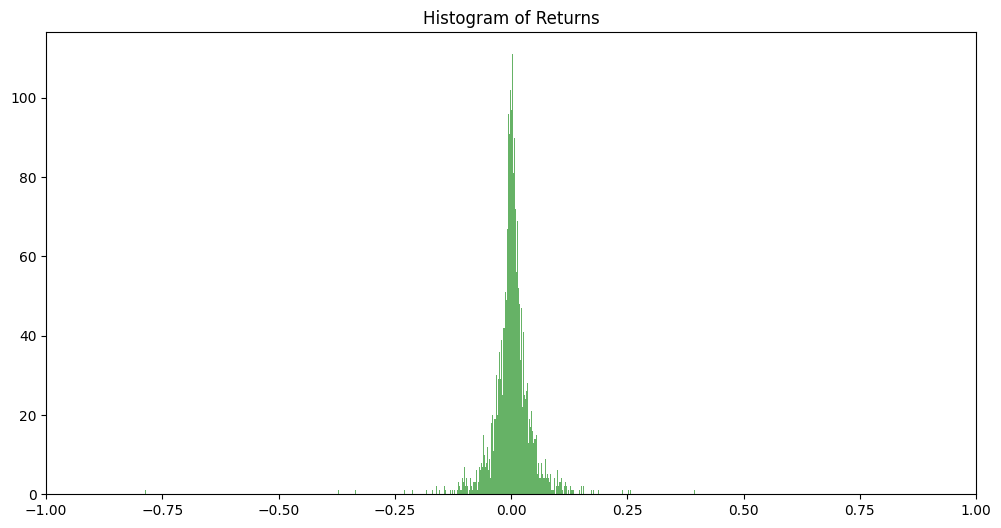

In [ ]:
#plot returns_weighted_price in histogram
import matplotlib.pyplot as plt
plt.figure(figsize=(12,6))
plt.hist(returns_weighted_price, bins=2998, alpha=0.6, color='g', label='Returns')
plt.title('Histogram of Returns')
#rescale of x axis from min max of returns_weighted_price
plt.xlim(-1, 1)

In [ ]:
#read accummulate_sharpe_ls_ from npy file
accummulate_sharpe_ls_ = np.load("accummulate_sharpe_ls_.npy")

In [ ]:
accummulate_sharpe_ls_.shape

(2998,)

In [ ]:
accummulate_sharpe_ls_.min()

-0.906117

In [ ]:
accummulate_sharpe_ls_.max()

0.21993653

(0.0, 100.0)

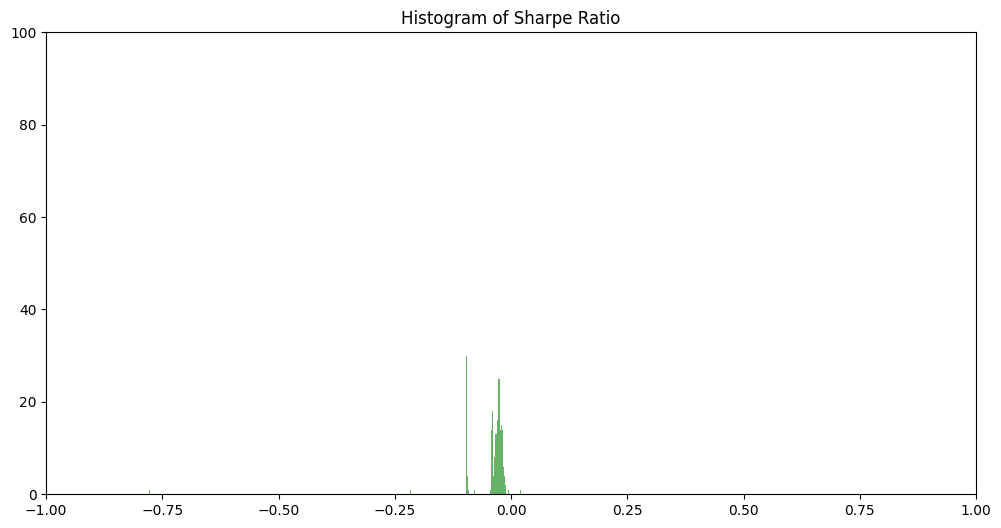

In [ ]:
#plot accummulate_sharpe_ls_ in histogram
import matplotlib.pyplot as plt
plt.figure(figsize=(12,6))
plt.hist(accummulate_sharpe_ls_, bins=2998, alpha=0.6, color='g', label='Returns')
plt.title('Histogram of Sharpe Ratio')
#rescale of x axis from min max of returns_weighted_price
plt.xlim(-1, 1)
#rescale of y axis from min max of returns_weighted_price
plt.ylim(0, 100)


Text(0.5, 1.0, 'Boxplot of Sharpe Ratio')

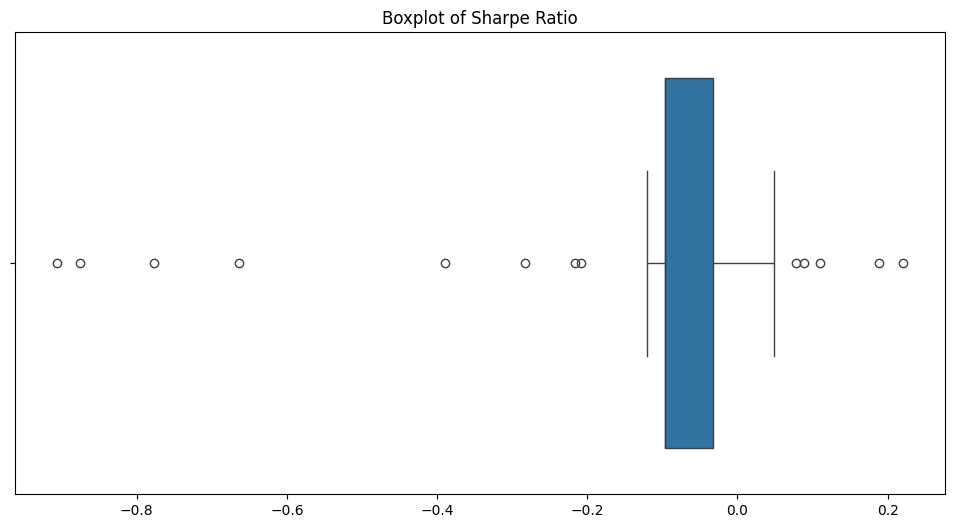

In [ ]:
#Show outliers of accummulate_sharpe_ls_
import seaborn as sns
plt.figure(figsize=(12,6))
sns.boxplot(x=accummulate_sharpe_ls_)
plt.title('Boxplot of Sharpe Ratio')


Text(0.5, 1.0, 'Scatter plot of Sharpe Ratio')

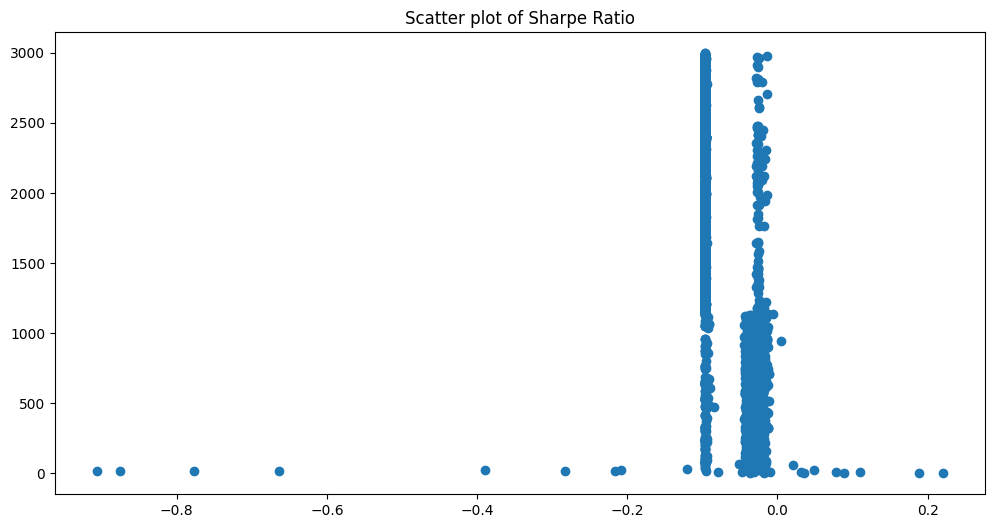

In [ ]:
#Show outliers of accummulate_sharpe_ls_ from scatter plot
plt.figure(figsize=(12,6))
plt.scatter(accummulate_sharpe_ls_,range(2998))
plt.title('Scatter plot of Sharpe Ratio')

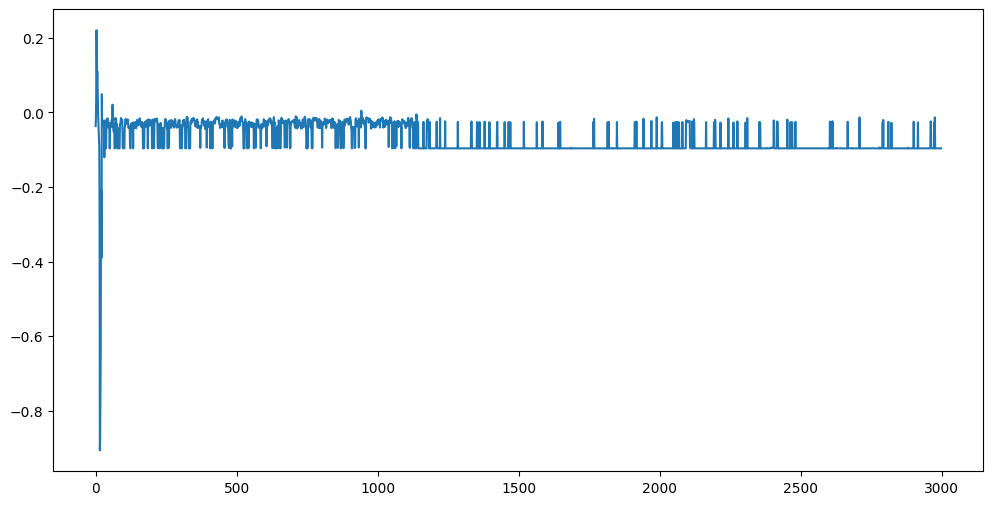

In [ ]:
#plot line graph of accummulate_sharpe_ls_
plt.figure(figsize=(12,6))
plt.plot(accummulate_sharpe_ls_)

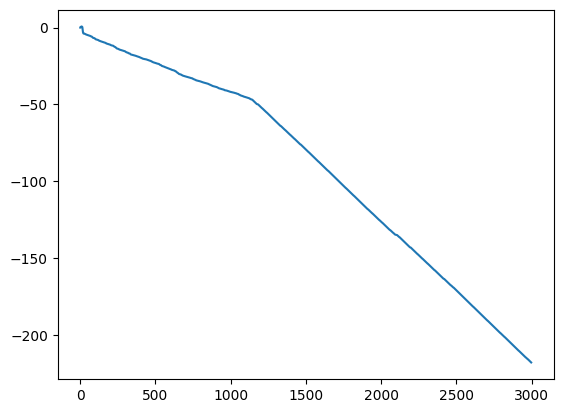

In [ ]:
#Create accummulate value of acccumulate_sharpe_ls_ for each day
plt.plot(accummulate_sharpe_ls_.cumsum())


In [ ]:
#Calculate sortino ratio
def sortino_ratio(returns, target=0):
    downside_returns = returns[returns < target]
    expected_return = returns.mean()
    downside_std = downside_returns.std()
    sortino_ratio = (expected_return - target) / downside_std
    return sortino_ratio

In [ ]:
#calculate calmar ratio
def calmar_ratio(returns, risk_free_rate=0.02):
    downside_returns = returns[returns < 0]
    expected_return = returns.mean()
    max_drawdown = (returns.cumsum() - returns.cumsum().cummax()).min()
    calmar_ratio = (expected_return - risk_free_rate) / abs(max_drawdown)
    return calmar_ratio

In [ ]:
calmar_ratio(returns_weighted_price)

-0.010372073020346805